# "Recognize insincere questions on Quora with BERT"
> "To tell if a question is sincere or not with BERT and fastai"

- toc:true
- branch: master
- badges: true
- comments: true
- author: Peiyi Hung
- categories: [category, project]
- image: 

In [1]:
import numpy as np
import pandas as pd

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from fastai.text.all import *
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset

In [2]:
path = "/kaggle/input/quora-insincere-questions-classification/"
train_df = pd.read_csv(path + "train.csv")
test_df = pd.read_csv(path + "test.csv")

In [3]:
train_df.shape, test_df.shape

((1306122, 3), (375806, 2))

In [4]:
train_df["target"].value_counts()/train_df.shape[0]

0    0.93813
1    0.06187
Name: target, dtype: float64

In [5]:
all_text = pd.concat([train_df["question_text"], test_df["question_text"]], axis=0)

In [6]:
def sample_text(n=10):
    sample = all_text.sample(n)
    print(" | ".join(sample))

In [7]:
sample_text()

Why do some women gain so much weight when they get pregnant and some women don't? | How can you extract bromine tetrafluoride from uranium? | How many websites (not web pages) are indexed in Google? | A fair coin is flipped 10 times. What is the probability of getting less than 4 heads? Use Table A-1 for Binomial Distribution. | What are your thoughts, plans and ideas to become an entrepreneur? | If you have 300K to invest in online business, what will you do? | Who should use a Roth 401k? | What are the most important qualities we should look for in a home cleaning professional before hiring them? | What are the best marketing channels for SaaS companies? | Do you have Mathematics optional?


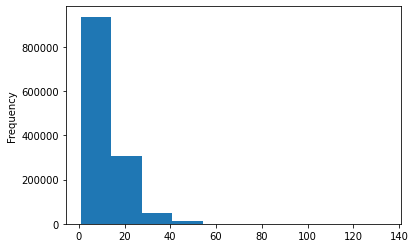

In [8]:
train_df["question_text"].apply(lambda x:len(x.split())).plot(kind="hist");

# Data

In [9]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

In [10]:
class QuestionDataset(Dataset):
    def __init__(self, X, y, tokenizer):
        self.text = X.reset_index(drop=True)
        self.targets = y.reset_index(drop=True)
        self.tok = tokenizer
    
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, idx):
        
        text = self.text[idx]
        targ = self.targets[idx]
        
        return self.tok(text, padding='max_length', 
                        truncation=True,
                        max_length=30,
                        return_tensors="pt")["input_ids"][0], tensor(targ)

In [11]:
df = train_df
X_train, X_valid, y_train, y_valid = train_test_split(df["question_text"], df["target"], 
                                                      stratify=df["target"],  test_size=0.01)

train_ds = QuestionDataset(X_train, y_train, tokenizer)
valid_ds = QuestionDataset(X_valid, y_valid, tokenizer)

train_dl = DataLoader(train_ds, bs=256)
valid_dl = DataLoader(valid_ds, bs=512)
dls = DataLoaders(train_dl, valid_dl).to("cuda")

# Model

In [12]:
bert = AutoModelForSequenceClassification.from_pretrained('bert-base-cased').train()

classifier = nn.Sequential(
    nn.Linear(768, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 2)
)

bert.classifier = classifier

class BertClassifier(Module):
    def __init__(self, bert):
        self.bert = bert
    def forward(self, x):
        x = self.bert(x)
        return x.logits

model = BertClassifier(bert).to("cuda")

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [13]:
n_0 = (train_df["target"] == 0).sum()
n_1 = (train_df["target"] == 1).sum()
n = n_0 + n_1

SuggestedLRs(lr_min=0.00014454397605732084, lr_steep=9.120108734350652e-05)

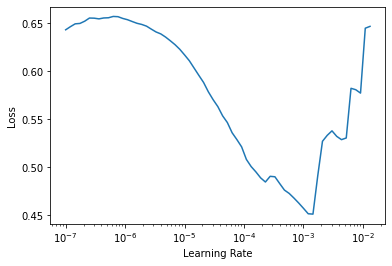

In [14]:
class_weights = tensor([n / (n+n_0), n / (n+n_1)]).to('cuda')
learn = Learner(dls, model, 
                loss_func=nn.CrossEntropyLoss(weight=class_weights), 
                metrics=[accuracy, F1Score()]).to_fp16()
learn.lr_find()

In [15]:
learn.fit_one_cycle(2, lr_max=5e-5)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.126460,0.127293,0.953300,0.688776,1:06:13
1,0.084351,0.122348,0.962027,0.715270,1:06:21


# Find the optimal threshold for f1 score

In [18]:
from sklearn.metrics import f1_score

In [16]:
preds, targs = learn.get_preds()

In [19]:
thresholds = np.linspace(0.3, 0.7, 50)
for threshold in thresholds:
    f1 = f1_score(targs, F.softmax(preds, dim=1)[:, 1]>threshold)
    print(f"threshold:{threshold:.4f} - f1:{f1:.4f}")

threshold:0.3000 - f1:0.7047
threshold:0.3082 - f1:0.7056
threshold:0.3163 - f1:0.7050
threshold:0.3245 - f1:0.7055
threshold:0.3327 - f1:0.7070
threshold:0.3408 - f1:0.7068
threshold:0.3490 - f1:0.7084
threshold:0.3571 - f1:0.7107
threshold:0.3653 - f1:0.7105
threshold:0.3735 - f1:0.7093
threshold:0.3816 - f1:0.7108
threshold:0.3898 - f1:0.7107
threshold:0.3980 - f1:0.7116
threshold:0.4061 - f1:0.7119
threshold:0.4143 - f1:0.7129
threshold:0.4224 - f1:0.7134
threshold:0.4306 - f1:0.7125
threshold:0.4388 - f1:0.7124
threshold:0.4469 - f1:0.7114
threshold:0.4551 - f1:0.7127
threshold:0.4633 - f1:0.7126
threshold:0.4714 - f1:0.7139
threshold:0.4796 - f1:0.7164
threshold:0.4878 - f1:0.7151
threshold:0.4959 - f1:0.7160
threshold:0.5041 - f1:0.7145
threshold:0.5122 - f1:0.7125
threshold:0.5204 - f1:0.7111
threshold:0.5286 - f1:0.7112
threshold:0.5367 - f1:0.7138
threshold:0.5449 - f1:0.7139
threshold:0.5531 - f1:0.7137
threshold:0.5612 - f1:0.7159
threshold:0.5694 - f1:0.7172
threshold:0.57

# Make prediction on test set

In [20]:
test_tensor = tokenizer(list(test_df["question_text"]),
                        padding="max_length",
                        truncation=True,
                        max_length=30,
                        return_tensors="pt")["input_ids"]

In [21]:
class TestDS:
    def __init__(self, tensors):
        self.tensors = tensors
    
    def __len__(self):
        return len(self.tensors)
    
    def __getitem__(self, idx):
        t = self.tensors[idx]
        return t, tensor(0)

test_dl = DataLoader(TestDS(test_tensor), bs=128)

In [22]:
test_preds = learn.get_preds(dl=test_dl)

In [23]:
prediction = (F.softmax(test_preds[0], dim=1)[:, 1]>0.48).int()
sub = pd.read_csv(path + "sample_submission.csv")
sub["prediction"] = prediction
sub.to_csv("submission.csv", index=False)